In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D , Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50,InceptionV3
from tensorflow.keras.applications.resnet50 import preprocess_input
#from tensorflow.keras.applications.inception_v3 import preprocess_input
from sklearn.metrics import classification_report,confusion_matrix
import itertools
import os
import matplotlib.pyplot as plt
import cv2
import random
import shutil
import requests
from sklearn.model_selection import train_test_split
%matplotlib inline
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        os.path.join(dirname, filename)
        #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
real_path = '/kaggle/input/dalle-recognition-dataset/real'
fake_path = '/kaggle/input/dalle-recognition-dataset/fakeV2/fake-v2'


In [4]:
base_dir = '/kaggle/working/dataset'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

for directory in [train_dir, val_dir, test_dir]:
    os.makedirs(os.path.join(directory, 'real'), exist_ok=True)
    os.makedirs(os.path.join(directory, 'fake'), exist_ok=True)

In [5]:
def split_data(SOURCE, TRAINING, VALIDATION, TEST, split_size=0.7, val_size=0.15):
    files = [f for f in os.listdir(SOURCE) if os.path.isfile(os.path.join(SOURCE, f))]
    
    train_files, test_files = train_test_split(files, test_size=1-split_size, random_state=42)
    val_files, test_files = train_test_split(test_files, test_size=1 - val_size / (1 - split_size), random_state=42)

    for file_name in train_files:
        shutil.copy(os.path.join(SOURCE, file_name), os.path.join(TRAINING, file_name))
    for file_name in val_files:
        shutil.copy(os.path.join(SOURCE, file_name), os.path.join(VALIDATION, file_name))
    for file_name in test_files:
        shutil.copy(os.path.join(SOURCE, file_name), os.path.join(TEST, file_name))


In [6]:
split_data(real_path, os.path.join(train_dir, 'real'), os.path.join(val_dir, 'real'), os.path.join(test_dir, 'real'))
split_data(fake_path, os.path.join(train_dir, 'fake'), os.path.join(val_dir, 'fake'), os.path.join(test_dir, 'fake'))

In [7]:
batch_size = 16
img_size = (224, 224)

data_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
)

# โหลดข้อมูลจากโฟลเดอร์ที่แบ่งไว้
train_batches = data_gen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
)

valid_batches = data_gen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
)

test_batches = data_gen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 15143 images belonging to 2 classes.
Found 3244 images belonging to 2 classes.
Found 3248 images belonging to 2 classes.


In [8]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
#base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(150,150,3))

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [9]:
for layer in base_model.layers:
    layer.trainable = False

In [10]:
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    #layers.Dense(128, activation='relu'),
    #layers.Dropout(0.5),
    layers.Dense(2, activation='softmax')  # Use 'softmax' for multi-class
])

In [11]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ ?                      │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

In [12]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
from PIL import Image
Image.MAX_IMAGE_PIXELS = None  # กำหนดเป็น None เพื่อปิดขีดจำกัด

In [14]:
history = model.fit(x=train_batches,
    #steps_per_epoch=len(train_batches),
    validation_data=valid_batches,
    #validation_steps=len(valid_batches),
    epochs=5,
    verbose=1
)

Epoch 1/5


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1730982704.947724     124 service.cc:145] XLA service 0x7882cc0024d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730982704.947782     124 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1730982704.947787     124 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  1/947 ━━━━━━━━━━━━━━━━━━━━ 3:45:24 14s/step - accuracy: 0.5625 - loss: 0.9908

I0000 00:00:1730982709.973641     124 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 25/947 ━━━━━━━━━━━━━━━━━━━━ 6:42 436ms/step - accuracy: 0.7931 - loss: 0.5775

/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


947/947 ━━━━━━━━━━━━━━━━━━━━ 427s 436ms/step - accuracy: 0.9061 - loss: 0.2628 - val_accuracy: 0.9420 - val_loss: 0.1714
Epoch 2/5
947/947 ━━━━━━━━━━━━━━━━━━━━ 390s 386ms/step - accuracy: 0.9469 - loss: 0.1512 - val_accuracy: 0.9383 - val_loss: 0.1726
Epoch 3/5
947/947 ━━━━━━━━━━━━━━━━━━━━ 365s 383ms/step - accuracy: 0.9537 - loss: 0.1284 - val_accuracy: 0.9396 - val_loss: 0.2136
Epoch 4/5
947/947 ━━━━━━━━━━━━━━━━━━━━ 363s 380ms/step - accuracy: 0.9544 - loss: 0.1289 - val_accuracy: 0.9350 - val_loss: 0.1752
Epoch 5/5
947/947 ━━━━━━━━━━━━━━━━━━━━ 364s 383ms/step - accuracy: 0.9612 - loss: 0.1121 - val_accuracy: 0.9507 - val_loss: 0.1502


In [15]:
predictions = model.predict(x=test_batches, steps=len(test_batches), verbose=0)

In [16]:
print(classification_report(test_batches.classes,np.argmax(predictions, axis = -1)))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      2680
           1       0.87      0.79      0.83       568

    accuracy                           0.94      3248
   macro avg       0.91      0.88      0.90      3248
weighted avg       0.94      0.94      0.94      3248



In [17]:
test_batches.class_indices

{'fake': 0, 'real': 1}

In [18]:
def classify_prediction(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.show()
    img = cv2.resize(img, (224, 224))
    img_array = np.array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)  # Apply preprocessing here
    
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=-1)
    print('FAKE:', predictions[0][0] * 100, '%')
    print('REAL:', predictions[0][1] * 100, '%')
    
    if predicted_class[0] == 0:
        print("This picture is FAKE")
    else:
        print("This picture is REAL")


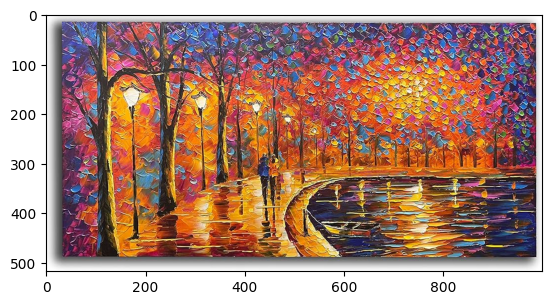

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
FAKE: 7.101032137870789 %
REAL: 92.89897084236145 %
This picture is REAL


In [19]:
url = 'https://m.media-amazon.com/images/I/81mfTJLkBLL._AC_UF1000,1000_QL80_.jpg'

response = requests.get(url)
image_array = np.asarray(bytearray(response.content), dtype=np.uint8)
img = cv2.imdecode(image_array, cv2.IMREAD_COLOR)
classify_prediction(img)


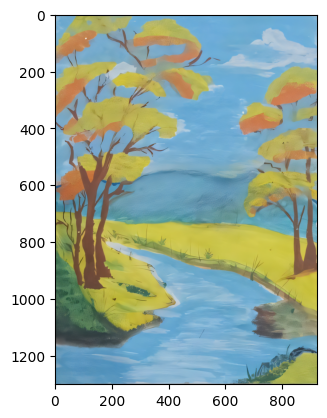

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
FAKE: 0.48212241381406784 %
REAL: 99.5178759098053 %
This picture is REAL


In [22]:
url = 'https://www.fitoor.com.pk/wp-content/uploads/2024/07/gtrey.png'

response = requests.get(url)
image_array = np.asarray(bytearray(response.content), dtype=np.uint8)
img = cv2.imdecode(image_array, cv2.IMREAD_COLOR)
classify_prediction(img)


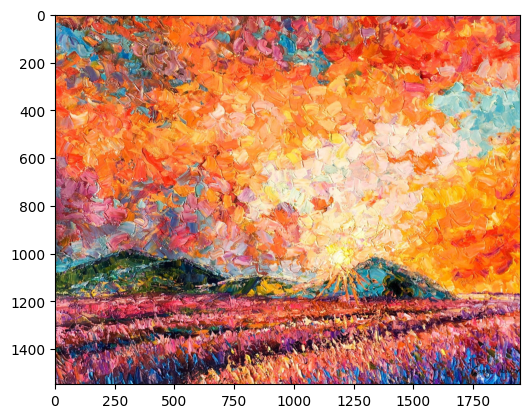

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
FAKE: 38.00353705883026 %
REAL: 61.99646592140198 %
This picture is REAL


In [23]:
url = 'https://georgemillerart.com/cdn/shop/products/il_fullxfull.2127209757_tgxt.jpg?v=1699571928&width=1946'

response = requests.get(url)
image_array = np.asarray(bytearray(response.content), dtype=np.uint8)
img = cv2.imdecode(image_array, cv2.IMREAD_COLOR)
classify_prediction(img)

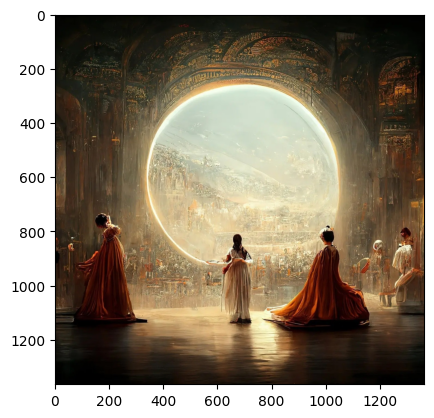

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
FAKE: 100.0 %
REAL: 9.296361014321519e-07 %
This picture is FAKE


In [25]:
url = "https://media.wired.com/photos/64f8c8a43e1a7b4810e35753/1:1/w_1365,h_1365,c_limit/AI-Copyright-The%CC%81a%CC%82tre_d'Ope%CC%81ra_Spatial-Culture.jpg"

response = requests.get(url)
image_array = np.asarray(bytearray(response.content), dtype=np.uint8)
img = cv2.imdecode(image_array, cv2.IMREAD_COLOR)
classify_prediction(img)

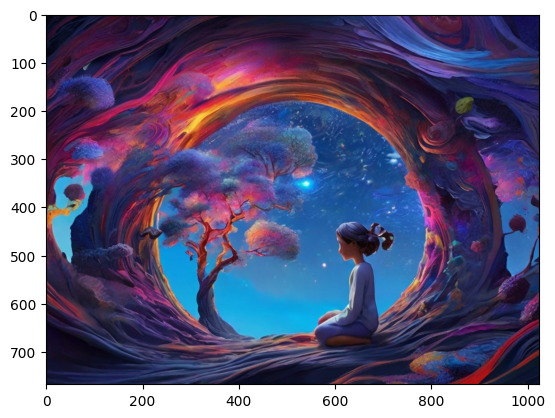

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
FAKE: 99.88980293273926 %
REAL: 0.11018902296200395 %
This picture is FAKE


In [27]:
url = "https://www.cognitivetoday.com/wp-content/uploads/2024/01/Creative-AI.jpg"

response = requests.get(url)
image_array = np.asarray(bytearray(response.content), dtype=np.uint8)
img = cv2.imdecode(image_array, cv2.IMREAD_COLOR)
classify_prediction(img)

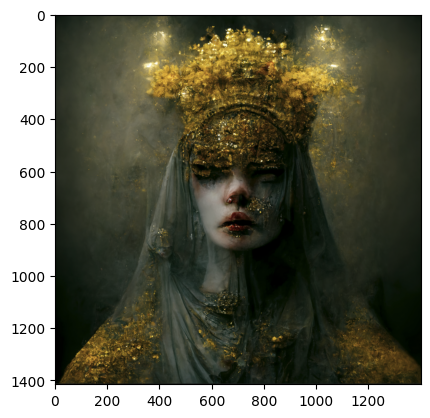

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
FAKE: 99.92424845695496 %
REAL: 0.07574582123197615 %
This picture is FAKE


In [28]:
url = "https://miro.medium.com/v2/resize:fit:1400/1*XoVCoIeNJ16PYOmWKOs0mg.png"

response = requests.get(url)
image_array = np.asarray(bytearray(response.content), dtype=np.uint8)
img = cv2.imdecode(image_array, cv2.IMREAD_COLOR)
classify_prediction(img)